# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

# import tensorflow as tf
# tf.config.experimental_run_functions_eagerly(True)
# tf.keras.backend.set_floatx('float64')

# import tensorflow.python.util.deprecation as deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import math
import time
import timeit
from   tqdm    import tqdm
import pandas  as pd
import numpy   as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot                        as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow
from   tensorflow.keras.models                  import *
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from utils.PerformanceMetrics import RegressionEvaluation


print('[INFO] Libraries imported')

[INFO] Libraries imported


# Parameters

In [3]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## CUDA

In [4]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

## Training paramers

In [5]:
Lag        =   12
Horizon    =    4
#
epochs     =  500
batch_size =   32

Transformation = True

# Importing data

In [6]:
# Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

In [7]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.67 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Preprocess

In [8]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
# df = pd.DataFrame( df[['Temperature', 'Humidity', 'NO2', 'CO']] )
df = pd.DataFrame( df[['NO2', 'CO']] )
# df = pd.DataFrame( df[ 'CO' ] )


df.head(3)

,NO2,CO
Date,,
2022-02-19 00:00:00,186.210526,248.947368
2022-02-19 00:05:00,151.052632,232.473684
2022-02-19 00:10:00,135.315789,226.947368


In [9]:
targetSeries = df.columns[-1]

## Include MA-based features

In [10]:
# df['MA6']  = df[ targetSeries ].rolling(6).mean()
# df['MA12'] = df[ targetSeries ].rolling(12).mean()
#
# df['MA5'] = df[ targetSeries ].rolling(5).mean()
# df['MA9'] = df[ targetSeries ].rolling(9).mean()

## Split Training/Testing set

In [11]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

In [12]:
print('Training: ', df_train.shape[0])
print('Testing:  ', df_test.shape[0])

Training:  17116
Testing:   4280


## Visualize Training & Testing data

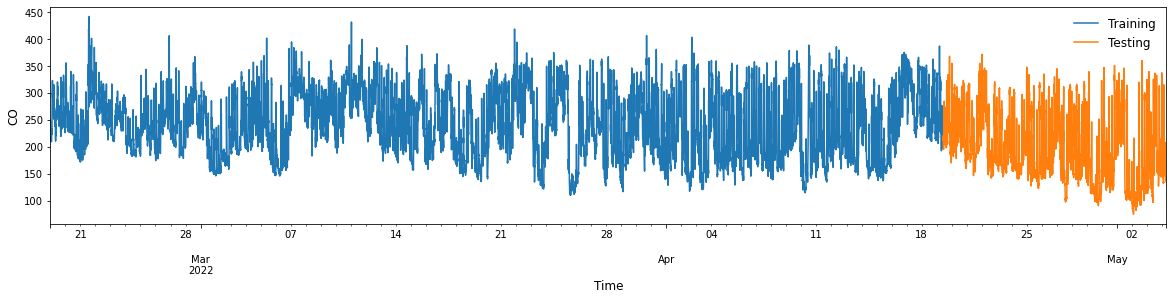

In [13]:
plt.figure( figsize = (20, 4) );
#
df_train[ targetSeries ].plot()
df_test[ targetSeries ].plot()
#
plt.legend(['Training', 'Testing'], fontsize = 12, frameon = False);
plt.ylabel( targetSeries, size = 12);
plt.xlabel( 'Time', size = 12);

## Fix lag

In [14]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Contruction of fitting data for training a forecasting model

### Data Transformation

In [15]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(-df.min().min(), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


### Data scaling 

In [16]:
for feature in df_train.columns:
    if (feature == targetSeries): continue

    # Setup scaler
    #
    scaler = StandardScaler()

    # Performing Scaling - for each feature
    df_train[feature] = scaler.fit_transform( df_train[feature].to_numpy().reshape(-1,1) )
    df_test[feature]  = scaler.transform( df_test[feature].to_numpy().reshape(-1,1) )


# Setup scaler
#
scaler = StandardScaler()

df_train[targetSeries] = scaler.fit_transform( df_train[targetSeries].to_numpy().reshape(-1,1) )
df_test[targetSeries]  = scaler.transform( df_test[targetSeries].to_numpy().reshape(-1,1) )

### Create fitting data 

In [17]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, includeLagData = False, includeDate = False, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        # Original data
        data       = df.to_numpy()[i+1:(i+Lag)]        
        
        # Include date info
        if (includeDate):            
            myDate = [ np.sin(df[i+1:(i+Lag)].index.hour + df[i+1:(i+Lag)].index.minute / 60 ).tolist(), 
                       np.cos(df[i+1:(i+Lag)].index.hour + df[i+1:(i+Lag)].index.minute / 60 ).tolist() ]
            myDate = np.asarray( myDate ).T
            #
            # Concatenate data            
            data = np.concatenate([data, myDate], axis = -1)

        # data_diff: Lag-d differences
        if (includeLagData):
            data_diff  = (df.iloc[i+Lag-1] - df.iloc[i:(i+Lag-1)]).to_numpy()
            #
            # Concatenate data
            data = np.concatenate([data, data_diff], axis = -1)
                
        
        # Concatenate data
        dataX.append( data )
        
        # Targets 
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )

In [18]:
trainX, trainY = create_dataset(df             = df_train, 
                                Lag            = Lag, 
                                Horizon        = Horizon, 
                                targetSeries   = targetSeries,
                                includeLagData = True,
                                includeDate    = False,
                                overlap        = 1)
                               

testX,  testY  = create_dataset(df             = df_test, 
                                Lag            = Lag, 
                                Horizon        = Horizon, 
                                targetSeries   = targetSeries,
                                includeLagData = True,
                                includeDate    = False,
                                overlap        = Horizon)


print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0] )

100%|██████████| 1070/1070 [00:01<00:00, 810.56it/s]

Training instances:    17101
Testing instances:      1070


# Forecasting model

In [19]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## Setup model

In [20]:
from tensorflow.python.keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.layers import Activation

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

        
get_custom_objects().update({'swish': Activation(swish)})



# from tensorflow.keras.utils  import get_custom_objects

def gelu(x):
    return 0.5 * x * (1 + tensorflow.tanh(tensorflow.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
    # return tf.keras.backend.hard_sigmoid(1.702 * x) * x

get_custom_objects().update({'gelu':  Activation(gelu)})

In [21]:
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.models                  import *

# Inputs
#
Inputs = Input(shape = (trainX.shape[1], trainX.shape[2]))


# Encoder
#
Encoder = LSTM(units = 100, activation='gelu')( Inputs )

# Decoder
#
Decoder = RepeatVector( Horizon )(Encoder)
#
Decoder = LSTM(units = 100, activation='gelu')( Decoder )
#
# Output
#
Outputs = Dense( Horizon, activation='linear' )( Decoder )


# Create model
#
model = Model(inputs = Inputs, outputs = Outputs)

2022-10-10 15:47:53.752842: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training forecasting model

In [22]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss      = 'mse', 
              optimizer = Adam(learning_rate = 5.e-4), 
              metrics   = metrics)

In [23]:
# Checkpoint
#
checkpoint = ModelCheckpoint("checkpoints/Hybrid.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 10)

In [24]:
# Start clock
#
start = timeit.default_timer()


score = model.fit(trainX, trainY, 
                  epochs           = epochs, 
                  batch_size       = batch_size, 
                  callbacks        = [checkpoint, earlystopping, lrs_scheduler],
                  verbose          = True, 
                  shuffle          = True,
                  validation_split = 0.2)


# Terminate clock
#
stop = timeit.default_timer()

Epoch 1/500
428/428 [==============================] - 19s 29ms/step - loss: 0.3231 - MAE: 0.4109 - RMSE: 0.5684 - val_loss: 0.2371 - val_MAE: 0.3450 - val_RMSE: 0.4870 - lr: 5.0000e-04
Epoch 2/500
428/428 [==============================] - 11s 25ms/step - loss: 0.1636 - MAE: 0.2707 - RMSE: 0.4045 - val_loss: 0.2242 - val_MAE: 0.3262 - val_RMSE: 0.4735 - lr: 5.0000e-04
Epoch 3/500
428/428 [==============================] - 11s 26ms/step - loss: 0.1593 - MAE: 0.2644 - RMSE: 0.3992 - val_loss: 0.2176 - val_MAE: 0.3128 - val_RMSE: 0.4665 - lr: 5.0000e-04
Epoch 4/500
428/428 [==============================] - 11s 26ms/step - loss: 0.1584 - MAE: 0.2639 - RMSE: 0.3980 - val_loss: 0.2174 - val_MAE: 0.3201 - val_RMSE: 0.4663 - lr: 5.0000e-04
Epoch 5/500
428/428 [==============================] - 11s 25ms/step - loss: 0.1575 - MAE: 0.2625 - RMSE: 0.3968 - val_loss: 0.2175 - val_MAE: 0.3204 - val_RMSE: 0.4664 - lr: 5.0000e-04
Epoch 6/500
428/428 [==============================] - 11s 26ms/step -

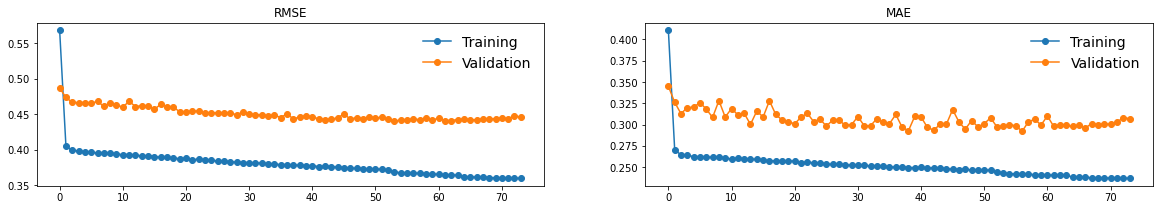

In [25]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'], marker = 'o');
ax[0].plot( score.history['val_RMSE'], marker = 'o');
ax[0].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAE'], marker = 'o');
ax[1].plot( score.history['val_MAE'], marker = 'o');
ax[1].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[1].set_title('MAE');

## Load optimized forecasting model

In [26]:
# Load the best model
#
model.load_weights('checkpoints/Hybrid.hdf5')

# Evaluation

## Get predictions

In [27]:
# Get predictions
#
pred = model.predict( testX )

## Apply inverse scaling/transformation

In [28]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred = np.exp( pred )   - VALUE

### Calculate Performance on Testing set

In [29]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
#     print('Horizon: ', i+1)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, SMAPE, R2) )

[INFO] Feature:  CO
------------------------------------------------
Horizon:  1 MAE  9.96 SMAPE:  4.98 R2: 0.94
Horizon:  2 MAE 17.63 SMAPE:  8.66 R2: 0.81
Horizon:  3 MAE 23.30 SMAPE: 11.51 R2: 0.70
Horizon:  4 MAE 27.56 SMAPE: 13.72 R2: 0.60


### Reliability evaluation

[INFO] Feature:  CO
------------------------------------------------


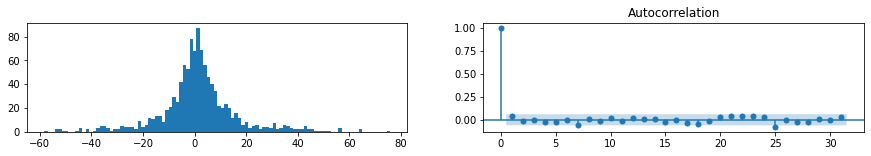

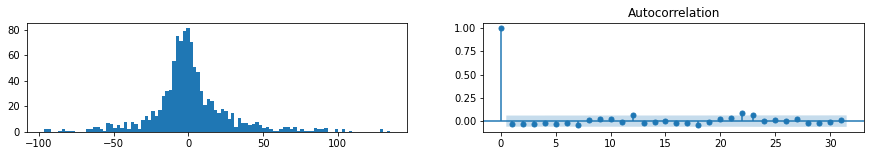

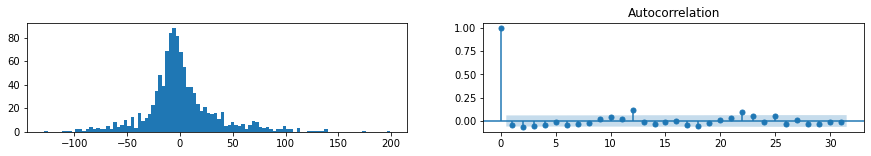

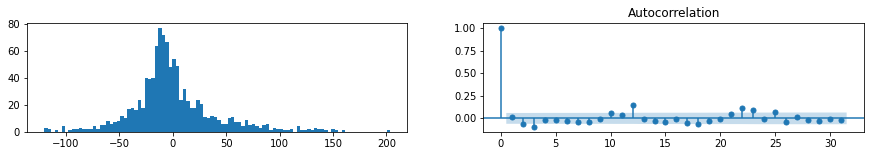

In [30]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
            
            

            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices[targetSeries] - Prices['Prediction']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Visualization of predictions

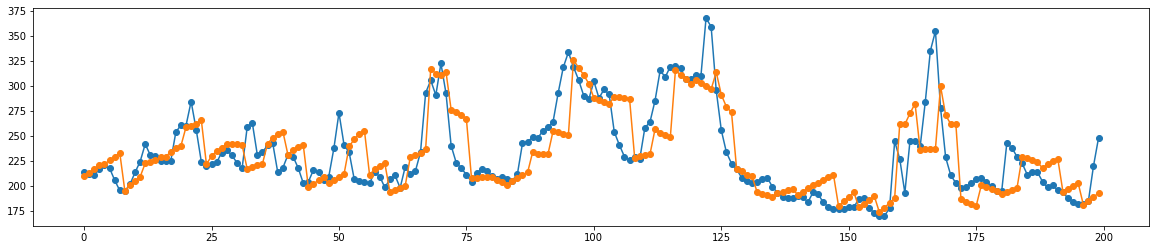

In [31]:
Prices = pd.DataFrame( [] )

Prices[targetSeries] = testY.flatten()
Prices['Prediction'] = pred.flatten()


# Plot results
#
plt.figure( figsize = (20, 4) );
#
Prices[ targetSeries ][:200].plot(color = 'tab:blue', marker = 'o')
Prices[ 'Prediction' ][:200].plot(color = 'tab:orange', marker = 'o')
plt.show();


### Examples

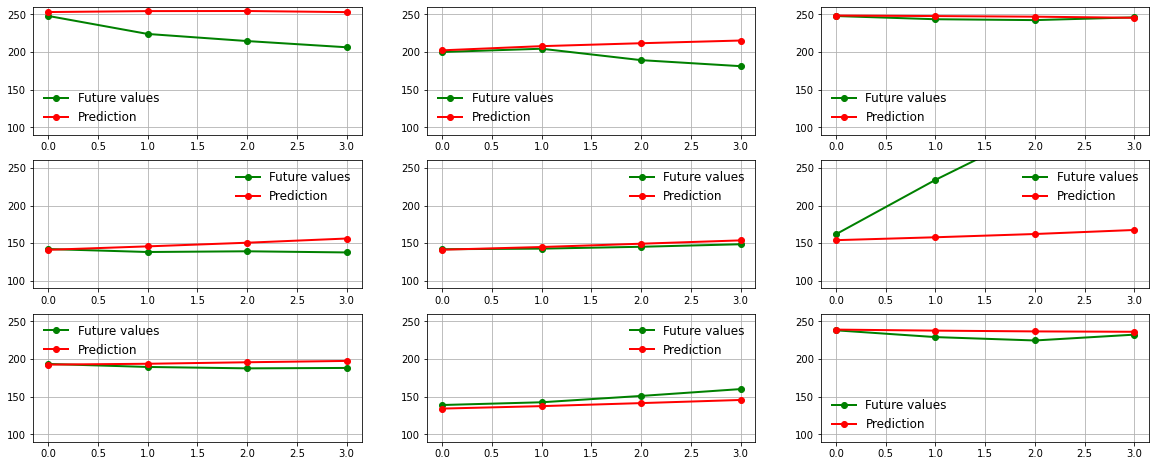

In [35]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]
RandomInstances = [66, 62, 192, 448, 477, 1035, 34, 408, 860]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()

    plt.plot(testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
    plt.ylim([90, 260])
plt.show()

# Store predictions

In [33]:
Outputs = pd.DataFrame( [] )


Outputs[ targetSeries ] = testY.flatten()
Outputs['Hybrid']       = pred.flatten()

Outputs.to_csv('Predictions/Hybrid.csv')